# Initial ocndition optimization
When optimizing the initial conditions of a dynamical system, computing gradients naively can be very expensive. Consider an $N$-body gravitational simulation: the system's state evolves according to Newton's laws, and a loss function $L$ depends on the state at a final time $T$. To adjust initial positions and velocities to minimize $L$, we need $\nabla L$ with respect to those initial conditions.

### Option 1: Backpropagation
We could simulate forward, store every intermediate state, and then apply discrete backpropagation. However, storing an entire trajectory (with many time steps) uses huge memory. For long simulations, this is infeasible.

### Option 2: Adjoint method
Instead of storing the trajectory, the adjoint method derives **co-state variables** (Lagrange multipliers) that can be integrated backward in time to compute gradients. This uses far less memory because we don't keep every intermediate state – we can recompute or integrate on the fly. I.e., the adjoint method tracks how the final loss $L(x(T))$ “flows backward” through the dynamics to influence initial conditions.

# The ODE
Consider a system governed by a second-order ODE (gravity). Let $x(t)\in \mathbb{R}^d$ and $p(t)\in \mathbb{R}^d$ be the generalized coordinates and the conjugate momenta. The equations of motion (EOMs) are, for $t\in[0,T]$:
$$
\begin{align}
\dot{x}(t) &= p(t) \\ 
\dot{p}(t) &= f\!\big(x(t)\big) \\
f(x(t)) &= \text{force field}
\end{align}
$$

**Initial conditions:** $x(0) = x_0$ and $p(0) = p_0$. 

**Terminal loss:** We define a loss function that depends on the state at final time $T$, $L\big(x(T)\big)$, which we aim to minimize by choosing appropriate $x_0, p_0$. The dependence on initial conditions is implicit, mediated by the ODE: $L = L(x(T(x_0, p_0)))$.

Our goal is to derive an expression for the gradient $\displaystyle \frac{\partial L}{\partial x_0}$ and $\displaystyle \frac{\partial L}{\partial p_0}$ using the adjoint method.





# The adjoint method

Imagine your simulation is governed by some differentiable time evolution, such as a differential equation or an update rule over time steps. You want to find how a loss function $L=\mathcal{L}(x(T))$, typically defined at the final time (e.g., comparing simulated and observed matter distribution), depends on initial parameters (e.g., initial positions/velocities or cosmological parameters). i.e., want to compute how a final loss $\mathcal{L}(x(T))$ depends on the initial condition $x(0)$, for an ODE:
$$\frac{dx}{dt} = f(x(t), t), \quad x(0) = x_0$$

## Setup the augmented Lagrangian
We want to minimize the loss $\mathcal{L}(x(T))$ subject to the ODE. This is **optimization with a constraint**: the system must obey the ODE. So we introduce time-dependent **Lagrange multipliers (adjoint variables)**. These adjoint variables will enforce that $x(t)$ and $p(t)$ follow the ODE while we vary the initial conditions.

Let 

$\lambda_x(t)\in \mathbb{R}^d$ correspond to the constraint $\dot{x} - p = 0$, and 

$\lambda_p(t)\in \mathbb{R}^d$ correspond to the constraint  $\dot{p} - f(x) = 0$. 

We construct an augmented Lagrangian (or action) over the time interval $[0,T]$ that incorporates the loss and these constraints:

$$
\red{\mathcal{L}[x, p, \lambda_x, \lambda_p] = L\big(x(T)\big) + \int_{0}^{T} \Big[\lambda_x(t)^\top \big(\dot{x}(t) - p(t)\big) + \lambda_p(t)^\top \big(\dot{p}(t) - f(x(t))\big)\Big] dt}.
$$

Here:
- The term $L(x(T))$ is the terminal loss.
- **The integral enforces the ODE**: if $(x,p)$ satisfy the dynamics, then $\dot{x}-p=0$ and $\dot{p}-f(x)=0$, making those integrand terms zero. If $(x,p)$ deviates, the Lagrange multipliers $\lambda_x,\lambda_p$ penalize the deviation. At optimum (when the constraints are satisfied), $\mathcal{L}$ equals the actual loss $L(x(T))$. We seek stationarity of $\mathcal{L}$ under variations of $x(t), p(t)$.

We now derive the adjoint equations by taking **variations** of the augmented Lagrangian $\mathcal{L}$. We treat $x(t), p(t), \lambda_x(t), \lambda_p(t)$ as **independent time-dependent functions**. Setting the first-order variation $\delta \mathcal{L}=0$ will yield:
1. The original state equations (from variations in $\lambda_x, \lambda_p$).
2.	The adjoint equations (from variations in $x, p$).
3.	Boundary conditions at $t=0$ and $t=T$ that relate the adjoint variables to gradients of $L$.


## Deriving the Adjoint Equations

Taking the variations:
$$
\begin{aligned}
\delta \mathcal{L} 
= \delta L(x(T)) 
 + \delta \int_0^T & \left[ \lambda_x^\top (\dot{x} - p) + \lambda_p^\top (\dot{p} - f(x)) \right] dt \\
= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) & \\
& + \int_0^T \delta \lambda_x^\top (\dot{x} - p) dt + \int_0^T \lambda_x^\top (\delta \dot{x} - \delta p) dt \\
& + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) dt + \int_0^T \lambda_p^\top (\delta \dot{p} - \frac{\partial f}{\partial x} \delta x) dt.
\end{aligned}
$$

When in doubt, integrate by parts: $\delta \dot{x}$ and $\delta \dot{p}$:

\begin{aligned}
\int_0^T \lambda_x^\top \delta \dot{x} \, dt &= \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \dot{\lambda}_x^\top \delta x \, dt, \\
\int_0^T \lambda_p^\top \delta \dot{p} \, dt &= \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \dot{\lambda}_p^\top \delta p \, dt.
\end{aligned}


Taking the variations:
$$
\begin{aligned}
\delta \mathcal{L} &= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) \quad \text{\red{terminal loss}} \\
&\quad + \int_0^T \delta \lambda_x^\top (\dot{x} - p) \, dt + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) \, dt \quad \text{\red{varying $\lambda$}} \\
&\quad + \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \dot{\lambda}_x^\top \delta x \, dt - \int_0^T \lambda_x^\top \delta p \, dt \quad \text{\red{varying $x,p$}} \\
&\quad + \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \dot{\lambda}_p^\top \delta p \, dt - \int_0^T \lambda_p^\top \frac{\partial f}{\partial x} \delta x \, dt \quad \text{\red{varying $x,p$}}
\end{aligned}
$$

Collecting terms:
$$
\begin{aligned}
\delta \mathcal{L} &= \frac{\partial L}{\partial x}(x(T))^\top \delta x(T) \quad \text{\red{terminal loss}} \\
&\quad + \int_0^T \delta \lambda_x^\top (\dot{x} - p) \, dt + \int_0^T \delta \lambda_p^\top (\dot{p} - f(x)) \, dt \quad \text{\red{varying $\lambda$}} \\
&\quad + \left[\lambda_x^\top \delta x \right]_0^T - \int_0^T \left[\dot{\lambda}_x^\top + \lambda_p^\top \frac{\partial f}{\partial x} \right] \delta x\, dt \quad \text{\red{varying $x,p$}} \\
&\quad + \left[\lambda_p^\top \delta p \right]_0^T - \int_0^T \left[\dot{\lambda}_p^\top + \lambda_x^\top \right] \delta p \, dt \quad \text{\red{varying $x,p$}}
\end{aligned}
$$

### Results:
Variation in $\delta \lambda_x$, $\delta \lambda_p$ yields the original dynamics:

\begin{aligned}
\delta \lambda_x: &\quad \dot{x} = p, \\
\delta \lambda_p: &\quad \dot{p} = f(x).
\end{aligned}

Variation in $\delta x$, $\delta p$ gives the adjoint equations:
\begin{aligned}
\dot{\lambda}_x &= -\left( \frac{\partial f}{\partial x} \right)^\top \lambda_p, \\
\dot{\lambda}_p &= -\lambda_x.
\end{aligned}

Boundary conditions:
\begin{aligned}
\delta x(T): &\quad \frac{\partial L}{\partial x}(x(T)) + \lambda_x(T) = 0, \quad \Rightarrow \quad \lambda_x(T) = -\frac{\partial L}{\partial x}(x(T)), \\
\delta p(T): &\quad \lambda_p(T) = 0, \\
\delta x(0): &\quad \text{free}, \quad \text{gives gradient wrt initial } x(0), \\
\delta p(0): &\quad \text{free}, \quad \text{gives gradient wrt initial } p(0).
\end{aligned}

### Summary
State equations (forward in time):
\begin{aligned}
\dot{x}(t) &= p(t), \\
\dot{p}(t) &= f(x(t)).
\end{aligned}

Adjoint equations (backward in time):
\begin{aligned}
\dot{\lambda}_x(t) &= -\left( \frac{\partial f}{\partial x}(x(t)) \right)^\top \lambda_p(t), \\
\dot{\lambda}_p(t) &= -\lambda_x(t),
\end{aligned}

with terminal conditions:
\begin{aligned}
\lambda_x(T) &= -\frac{\partial L}{\partial x}(x(T)), \\
\lambda_p(T) &= 0 \quad \text{\red{since $L$ does not depend on $p(T)$}}
\end{aligned}

### 4. Summary
We have obtained a coupled first-order system for the adjoint variables:
$$
\begin{align*}
\dot{\lambda}_x(t) &= -\Big(\frac{\partial f}{\partial x}(x(t))\Big)^\top \lambda_p(t) \\
\dot{\lambda}_p(t) &= -\lambda_x(t) \\
\end{align*}
$$
to be satisfied for $0 < t < T$ where, 

\begin{aligned}
\lambda_x(T) &= -\frac{\partial L}{\partial x}(x(T)), \\
\lambda_p(T) &= 0 \quad \text{\red{since $L$ does not depend on $p(T)$}}
\end{aligned}

and the gradient of the loss with respect to the initial conditions is given by:
$$
\begin{aligned}
\frac{\partial L}{\partial x} (0) &= -\lambda_x(0), \\
\frac{\partial L}{\partial p} (0) &= -\lambda_p(0).
\end{aligned}


# Demo: Harmonic Oscillator

Setup:
\begin{aligned}
\dot{x}(t) &= p(t), \\
\dot{p}(t) &= -k x(t),
\end{aligned}
with terminal loss:
$$L(x(T)) = \frac{1}{2} x(T)^2.$$

The adjoint equations (backward in time):
\begin{aligned}
\dot{\lambda}_x(t) &= k \lambda_p(t), \\
\dot{\lambda}_p(t) &= -\lambda_x(t),
\end{aligned}
with final condition:
$$\lambda_x(T) = \frac{dL}{dx(T)} = x(T), \quad \lambda_p(T) = 0.$$

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Harmonic oscillator
# Forward ODE
def forward_step(x, p, k, dt):
    dx = p
    dp = -k * x
    x_new = x + dt * dx
    p_new = p + dt * dp
    return x_new, p_new

# Adjoint (backward) ODE
def adjoint_step(λx, λp, x, p, k, dt):
    dλx = k * λp
    dλp = -λx
    # backward in time!
    λx_new = λx - dt * dλx  
    λp_new = λp - dt * dλp
    return λx_new, λp_new

# Integration loop
def simulate(k=1.0, x0=1.0, p0=0.0, T=5.0, N=200):
    dt = T / N
    ts = jnp.linspace(0, T, N+1)

    # Forward simulation
    xs, ps = [x0], [p0]
    x, p = x0, p0
    for _ in range(N):
        x, p = forward_step(x, p, k, dt)
        xs.append(x)
        ps.append(p)
    xs, ps = jnp.array(xs), jnp.array(ps)

    # Terminal loss and adjoint init
    xT = xs[-1] # final state
    dLdxT = xT  # d/dx 0.5 x^2 = x
    λx, λp = dLdxT, 0.0 # the initial condition for adjoint variables

    # Backward simulation
    λxs, λps = [λx], [λp]
    for i in reversed(range(N)):
        λx, λp = adjoint_step(λx, λp, xs[i], ps[i], k, dt)
        λxs.append(λx)
        λps.append(λp)
    λxs = jnp.array(λxs[::-1])
    λps = jnp.array(λps[::-1])

    return ts, xs, ps, λxs, λps

### Forward and adjoint dynamics

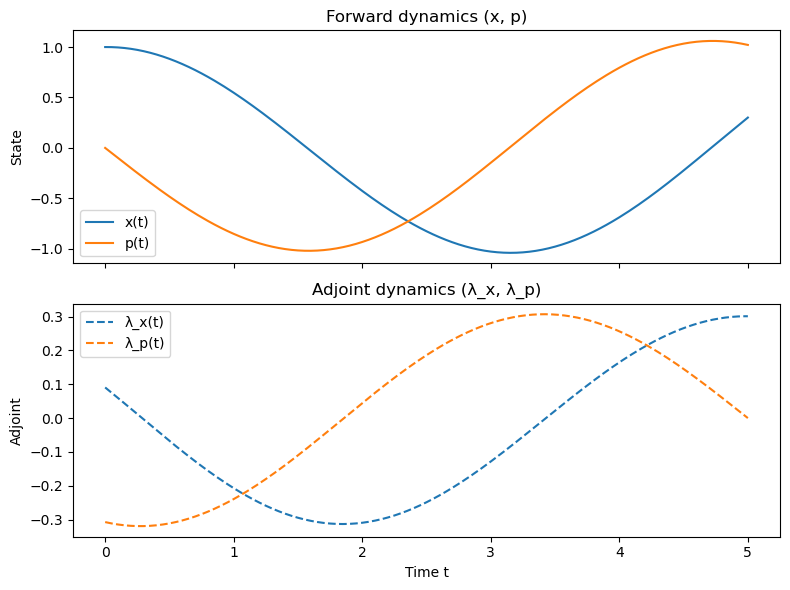

In [4]:
# Run and visualize
ts, xs, ps, λxs, λps = simulate()

# Plot
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].plot(ts, xs, label='x(t)')
axs[0].plot(ts, ps, label='p(t)')
axs[0].set_ylabel('State')
axs[0].legend()
axs[0].set_title('Forward dynamics (x, p)')

axs[1].plot(ts, λxs, label='λ_x(t)', linestyle='--')
axs[1].plot(ts, λps, label='λ_p(t)', linestyle='--')
axs[1].set_ylabel('Adjoint')
axs[1].set_xlabel('Time t')
axs[1].legend()
axs[1].set_title('Adjoint dynamics (λ_x, λ_p)')

plt.tight_layout()
plt.show()

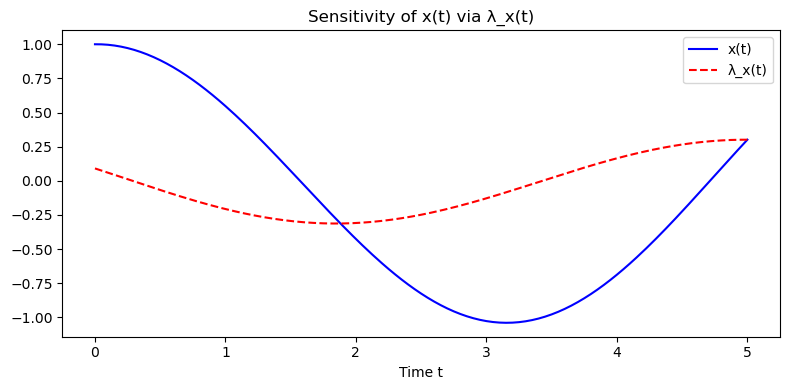

In [7]:
ts, xs, ps, λxs, λps = simulate(x0=1.0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ts, xs, label='x(t)', color='blue')
ax.plot(ts, λxs, label='λ_x(t)', color='red', linestyle='--')
ax.set_title('Sensitivity of x(t) via λ_x(t)')
ax.set_xlabel('Time t')
ax.legend()
plt.tight_layout()
plt.show()


### Verify the gradient

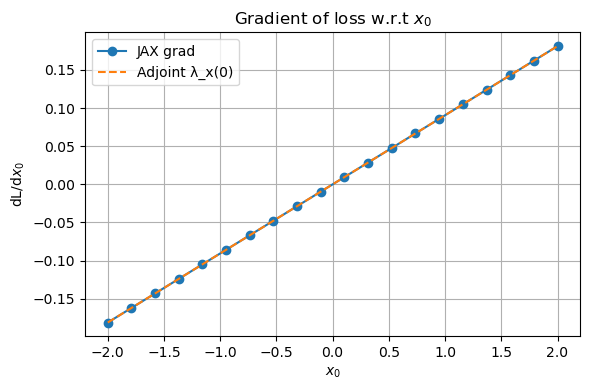

In [10]:
x0s = jnp.linspace(-2, 2, 20)
trajectories = []
losses = []
adjoint_grads = []

for x0 in x0s:
    ts, xs, ps, λxs, λps = simulate(x0=x0)
    trajectories.append(xs)
    losses.append(0.5 * xs[-1]**2)
    adjoint_grads.append(λxs[0])
trajectories = jnp.stack(trajectories)

losses = jnp.array(losses)
adjoint_grads = jnp.array(adjoint_grads)

def loss_fn(x0):
    ts, xs, ps, _, _ = simulate(x0=x0)
    return 0.5 * xs[-1]**2

grad_fn = jax.grad(loss_fn)
autodiff_grads = jnp.array([grad_fn(x0) for x0 in x0s])

# Plot comparison
plt.figure(figsize=(6, 4))
plt.plot(x0s, autodiff_grads, label='JAX grad', marker='o')
plt.plot(x0s, adjoint_grads, label='Adjoint λ_x(0)', linestyle='--')
plt.title('Gradient of loss w.r.t $x_0$')
plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('dL/d$x_0$', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Sensitivity analysis

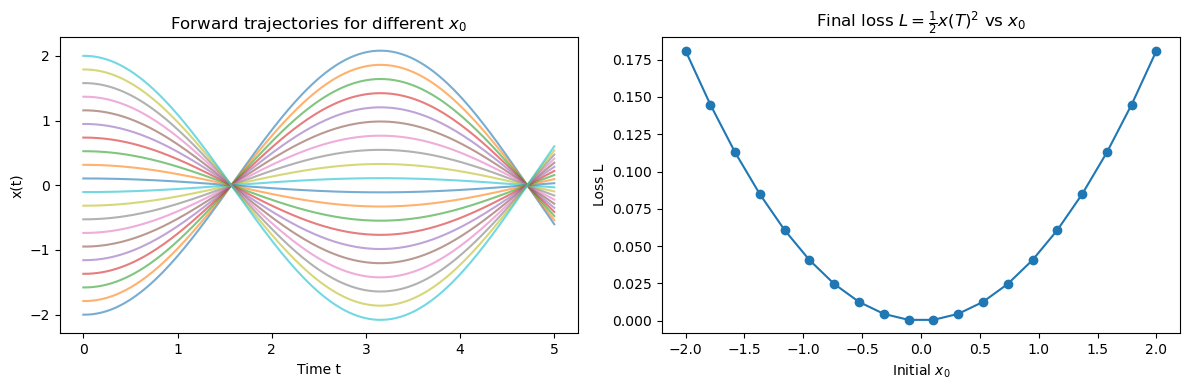

In [11]:
# -------------------------------------
# Sweep over initial x0 to compute the trajectory and loss
# -------------------------------------
x0s = jnp.linspace(-2, 2, 20)
trajectories = []
losses = []
adjoint_grads = []

for x0 in x0s:
    ts, xs, ps, λxs, λps = simulate(x0=x0)
    trajectories.append(xs)
    losses.append(0.5 * xs[-1]**2)
    adjoint_grads.append(λxs[0])

trajectories = jnp.stack(trajectories)
losses = jnp.array(losses)
adjoint_grads = jnp.array(adjoint_grads)

# -------------------------------------
# Left (trajectories), Right (loss vs x0)
# -------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for i in range(len(x0s)):
    ax1.plot(ts, trajectories[i], alpha=0.6)
ax1.set_title('Forward trajectories for different $x_0$')
ax1.set_xlabel('Time t')
ax1.set_ylabel('x(t)')

ax2.plot(x0s, losses, marker='o')
ax2.set_title('Final loss $L=\\frac{1}{2}x(T)^2$ vs $x_0$')
ax2.set_xlabel('Initial $x_0$')
ax2.set_ylabel('Loss L')

plt.tight_layout()
plt.show()


Gradient with Respect to Initial Conditions via the Adjoint

Having obtained $\lambda_x(t)$ and $\lambda_p(t)$, we can now express the gradient of the loss $L$ with respect to the initial state $(x_0, p_0)$. Intuitively, $\lambda_x(0)$ and $\lambda_p(0)$ will relate to those gradients. From the boundary variation at $t=0$, we saw:
$$
\delta \mathcal{L} \big|_{t=0} = -,\lambda_x(0)^\top ,\delta x(0);-;\lambda_p(0)^\top, \delta p(0),.
$$
But at optimum (with constraints satisfied), $\mathcal{L}$ equals the true loss $L(x(T))$ (because the constraint term vanishes for the true trajectory). So $\delta \mathcal{L}$ equals $\delta L$ for variations via initial conditions. Therefore:
$$
\delta L = -,\lambda_x(0)^\top \delta x_0 - \lambda_p(0)^\top \delta p_0,.
$$

This must hold for arbitrary small changes $\delta x_0, \delta p_0$, so we identify the gradient:
$$
\nabla_{x_0} L = -,\lambda_x(0), \qquad
\nabla_{p_0} L = -,\lambda_p(0),.
$$

(Note: In our derivation, the negative signs appear because of how we set up the Lagrangian. Another common convention is to define the adjoint variables with opposite sign, which leads to $\nabla_{x_0} L = \lambda_x(0)$. The end result is equivalent — what matters is that we correctly compute $\lambda(0)$ by integrating from the known final condition. We’ll keep the convention as derived.)

How to compute the gradient in practice: The adjoint method yields a clear algorithm for computing the gradient w.rt initial conditions without computing expensive finite differences:
	1.	Forward integration (solve the primal system): Starting from $(x(0)=x_0,;p(0)=p_0)$, integrate the state ODEs $\dot{x}=p,; \dot{p}=f(x)$ forward to time $T$. Record the final state $x(T)$ (and $p(T)$ if needed).
	2.	Initialize adjoints at $t=T$:
	•	Set $\displaystyle \lambda_x(T) = \nabla_x L\big(x(T)\big)$ (the gradient of the loss with respect to the final position).
	•	Set $\displaystyle \lambda_p(T) = \nabla_p L\big(x(T)\big)$. If $L$ does not depend on final momentum, then $\lambda_p(T)=0$.
	3.	Backward integration (solve the adjoint system): Integrate the adjoint equations backward in time from $t=T$ to $t=0$:
$$
\dot{\lambda}_x(t) = - \Big(\frac{\partial f}{\partial x}(x(t))\Big)^\top \lambda_p(t),
\qquad
\dot{\lambda}_p(t) = -,\lambda_x(t),,
$$
using the initial conditions from step 2 at $t=T$ (here “initial” means starting the backward integration).
At each time step (backwards), you use the stored or recomputed forward state $x(t)$ to evaluate the Jacobian $\partial f/\partial x$. This coupling ensures the adjoint is following the gradients along the same trajectory.
	4.	Read off gradients at $t=0$:
	•	The result of the backward integration gives $\lambda_x(0)$ and $\lambda_p(0)$. According to the relation above,
$$
\nabla_{x_0} L = -,\lambda_x(0), \qquad
\nabla_{p_0} L = -,\lambda_p(0),.
$$
These are the gradients of the loss with respect to the initial position and momentum. They tell us how a small change in $x_0$ or $p_0$ will change the final loss $L$.

This adjoint procedure computes the gradient in roughly the cost of two simulations (one forward, one backward), regardless of the number of parameters (which here are the components of $x_0,p_0$). In contrast, a brute-force finite difference approach would require dozens or hundreds of forward simulations (one per parameter perturbation), and naive backpropagation would require storing a full trajectory in memory. The adjoint method is therefore much more efficient.

How to compute the gradient in practice: The adjoint method yields a clear algorithm for computing the gradient w.rt initial conditions without computing expensive finite differences:
	1.	Forward integration (solve the primal system): Starting from $(x(0)=x_0,;p(0)=p_0)$, integrate the state ODEs $\dot{x}=p,; \dot{p}=f(x)$ forward to time $T$. Record the final state $x(T)$ (and $p(T)$ if needed).
	2.	Initialize adjoints at $t=T$:
	•	Set $\displaystyle \lambda_x(T) = \nabla_x L\big(x(T)\big)$ (the gradient of the loss with respect to the final position).
	•	Set $\displaystyle \lambda_p(T) = \nabla_p L\big(x(T)\big)$. If $L$ does not depend on final momentum, then $\lambda_p(T)=0$.
	3.	Backward integration (solve the adjoint system): Integrate the adjoint equations backward in time from $t=T$ to $t=0$:
$$
\dot{\lambda}_x(t) = - \Big(\frac{\partial f}{\partial x}(x(t))\Big)^\top \lambda_p(t),
\qquad
\dot{\lambda}_p(t) = -,\lambda_x(t),,
$$
using the initial conditions from step 2 at $t=T$ (here “initial” means starting the backward integration).
At each time step (backwards), you use the stored or recomputed forward state $x(t)$ to evaluate the Jacobian $\partial f/\partial x$. This coupling ensures the adjoint is following the gradients along the same trajectory.
	4.	Read off gradients at $t=0$:
	•	The result of the backward integration gives $\lambda_x(0)$ and $\lambda_p(0)$. According to the relation above,
$$
\nabla_{x_0} L = -,\lambda_x(0), \qquad
\nabla_{p_0} L = -,\lambda_p(0),.
$$
These are the gradients of the loss with respect to the initial position and momentum. They tell us how a small change in $x_0$ or $p_0$ will change the final loss $L$.

This adjoint procedure computes the gradient in roughly the cost of two simulations (one forward, one backward), regardless of the number of parameters (which here are the components of $x_0,p_0$). In contrast, a brute-force finite difference approach would require dozens or hundreds of forward simulations (one per parameter perturbation), and naive backpropagation would require storing a full trajectory in memory. The adjoint method is therefore much more efficient.

Example: Simple Harmonic Oscillator

To make these ideas concrete, consider a simple harmonic oscillator in one dimension. This system follows $\ddot{x}(t) + \omega^2 x(t) = 0$, or equivalently:
$$
\dot{x}(t) = v(t), \qquad
\dot{v}(t) = -,\omega^2,x(t),,
$$
where $v=\dot{x}$ and $\omega$ is the oscillator frequency. We will apply the adjoint method to this system to compute the sensitivity of a simple terminal cost.

Setup: Let the loss be $L(x(T)) = \frac{1}{2}[x(T) - X_{\text{target}}]^2$, which penalizes the difference between the final position $x(T)$ and some target $X_{\text{target}}$. The gradient $\nabla_x L(x(T)) = x(T) - X_{\text{target}}$ (and $\nabla_v L=0$ since $L$ does not depend on $v(T)$).


### Appendix: Variation with respect to $\lambda_x$ and $\lambda_p$

$$
\mathcal{L}[x, p, \lambda_x, \lambda_p] = L\big(x(T)\big) + \int_{0}^{T} \Big[\lambda_x(t)^\top \big(\dot{x}(t) - p(t)\big) + \lambda_p(t)^\top \big(\dot{p}(t) - f(x(t))\big)\Big] dt.
$$


Variation with respect to $\lambda_x$ and $\lambda_p$: This simply reproduces the constraints (the forward ODE). Treating $\lambda_x,\lambda_p$ as Lagrange multipliers, we require:
- $\displaystyle \frac{\delta \mathcal{L}}{\delta \lambda_x(t)} = 0 \implies \dot{x}(t) - p(t) = 0,$
- $\displaystyle \frac{\delta \mathcal{L}}{\delta \lambda_p(t)} = 0 \implies \dot{p}(t) - f(x(t)) = 0.$

These are exactly the original equations of motion, as expected.


$$
\mathcal{L}[x, p, \lambda_x, \lambda_p] = L\big(x(T)\big) + \int_{0}^{T} \Big[\lambda_x(t)^\top \big(\dot{x}(t) - p(t)\big) + \lambda_p(t)^\top \big(\dot{p}(t) - f(x(t))\big)\Big] dt.
$$


We get two contributions:
	•	From the terminal loss: $L(x(T)) \Rightarrow \delta L = \nabla_x L(x(T))^\top \delta x(T)$
	•	From the integral term:
	•	$\int_0^T \lambda_p^\top (-\delta f(x)) dt = \int_0^T -\lambda_p^\top \nabla f(x) \delta x , dt$

But we also need to consider the term $\lambda_x^\top \dot{x}$:
	•	$\int_0^T \lambda_x^\top \dot{x} , dt \Rightarrow -\int_0^T \dot{\lambda}_x^\top \delta x , dt + \left[\lambda_x^\top \delta x\right]_0^T$

So putting all together:

$$
\delta \mathcal{L} = \nabla_x L(x(T))^\top \delta x(T) + \int_0^T \left( -\dot{\lambda}_x(t) - \nabla f(x(t))^\top \lambda_p(t) \right)^\top \delta x(t) , dt + \left[\lambda_x(t)^\top \delta x(t)\right]_0^T
$$

From variation in $x(t)$:
$$
\boxed{\dot{\lambda}_x(t) = - \nabla f(x(t))^\top \lambda_p(t)}
$$

From variation in $p(t)$:
$$
\boxed{\dot{\lambda}_p(t) = - \lambda_x(t)}
$$

### 2. Variation with respect to $x(t)$ (state variable): 
The $x$-dependence in $\mathcal{L}$ comes from two places:
- the terminal loss $L(x(T))$, and
- the integrand $\lambda_p(t)^\top[-f(x(t))]$ (since $-f(x)$ depends on $x$).

Let $\nabla_x L(x(T))$ denote the gradient of the loss w.rt final state $x(T)$. A small variation $\delta x(t)$ yields:
- Terminal contribution (at $t=T$): $\delta L(x(T)) = \nabla_x L\big(x(T)\big)^\top ,\delta x(T)$.
- Integral contribution: $\int_0^T \lambda_p(t)^\top \left[-\frac{\partial f(x(t))}{\partial x} ,\delta x(t)\right] dt$. (Here $\partial f/\partial x$ is the Jacobian matrix of $f$; its transpose will appear shortly.)

There is also $x$ inside $\dot{p}-f(x)$, but we handle that via integration by parts on the $\lambda_p \dot{p}$ term when varying $p$; we will handle $p$-variation separately. The $\lambda_x(\dot{x}-p)$ term also has $x$ via $\dot{x}$; we integrate by parts to transfer the time derivative off $\delta x$. Performing integration by parts on the $\lambda_x \dot{x}$ term:

$$
\int_0^T \lambda_x(t)^\top \dot{x}(t),dt = \Big[\lambda_x(t)^\top x(t)\Big]_0^T - \int_0^T \dot{\lambda}_x(t)^\top, x(t),dt,,
$$

so in the variation we get a bulk term involving $-\dot{\lambda}_x(t)^\top \delta x(t)$ and boundary terms $\lambda_x(T)^\top \delta x(T) - \lambda_x(0)^\top \delta x(0)$.

Collecting all terms proportional to $\delta x(t)$ (and using that $\delta x(t)$ is arbitrary for $0<t<T$), we obtain the adjoint equation for $\lambda_x(t)$:

$$
-\dot{\lambda}_x(t) - \left[\frac{\partial f(x(t))}{\partial x}\right]^\top \lambda_p(t) = 0 \qquad \implies \qquad
\dot{\lambda}_x(t) = - \Big(\frac{\partial f}{\partial x}\big(x(t)\big)\Big)^\top \lambda_p(t),.
$$

This is a first-order ODE for the multiplier $\lambda_x(t)$. It shows that $\lambda_x(t)$ is driven by the Jacobian of the force field $f$. The minus sign indicates that the adjoint propagates opposite to the direction that a perturbation in $x$ would affect $p$ forward in time.

### 3. Variation with respect to $p(t)$: 
The $p$-dependence in $\mathcal{L}$ appears in:
- the term $\lambda_x^\top(-p)$ in the integrand,
- the $\lambda_p \dot{p}$ term (which we integrate by parts),
- and possibly in the terminal loss $L(x(T))$ if $L$ depended on $p(T)$ (which we’re assuming it does not, so we ignore any $\nabla_p L$ term at $T$ for now).

Performing integration by parts on $\int_0^T \lambda_p^\top \dot{p},dt$ gives $\Big[\lambda_p(t)^\top p(t)\Big]_0^T - \int_0^T \dot{\lambda}_p(t)^\top p(t),dt$. Variation $\delta p(t)$ yields:
- From $-\lambda_x^\top p$: a term $-(\lambda_x(t))^\top \delta p(t)$ in the integrand.
- From integration by parts of $\lambda_p \dot{p}$: a bulk term $-\dot{\lambda}_p(t)^\top \delta p(t)$ and boundary terms $\lambda_p(T)^\top \delta p(T) - \lambda_p(0)^\top \delta p(0)$.

Setting the bulk term coefficient to zero gives the adjoint equation for $\lambda_p(t)$:

$$
-(1)\lambda_x(t) - \dot{\lambda}_p(t) = 0 \qquad \implies \qquad
\dot{\lambda}_p(t) = -,\lambda_x(t),.
$$

(If we had kept the mass $m$ symbolic, this would be $\dot{\lambda}_p = -,\frac{1}{m}\lambda_x$ because $\partial(\frac{p}{m})/\partial p = \frac{1}{m}I$. We have taken $m=1$.)

This adjoint equation shows that $\lambda_p(t)$ is directly driven by $-\lambda_x(t)$. In fact, combining the two adjoint ODEs, one can differentiate $\dot{\lambda}_p = -\lambda_x$ once more and eliminate $\lambda_x$ to get $\ddot{\lambda}_p(t) = -\dot{\lambda}_x(t) = \big(\partial f/\partial x\big)^\top \lambda_p(t)$, which is the adjoint system’s second-order form (mirroring the original second-order dynamics). But it’s usually easier to work with the first-order system for $(\lambda_x, \lambda_p)$.


### 4. Summary
We have obtained a coupled first-order system for the adjoint variables:
$$
\begin{align*}
\dot{\lambda}_x(t) &= -\Big(\frac{\partial f}{\partial x}(x(t))\Big)^\top \lambda_p(t) \\
\dot{\lambda}_p(t) &= -\lambda_x(t) \\
\end{align*}
$$
to be satisfied for $0 < t < T$. These are linear ODEs along the trajectory, since they depend on the known forward solution $x(t)$.


The adjoint method allows you to compute:
$$
\frac{dL}{d\theta}
$$
for some parameter $\theta$, efficiently without backpropagating through the entire simulation like in naive autodiff (which would be memory-intensive). Instead, the adjoint method solves another differential equation backward in time, called the adjoint equation.


## Some intuitions

We want to minimize the loss:
$\mathcal{L}(x(T))$
subject to:
$$\frac{dx}{dt} = f(x(t), t), \quad x(0) = x_0$$

This is an optimization with a constraint: the system must obey the ODE. So we introduce the Lagrange multipliers (the **adjoint** variables) and treat this like a variational problem.

Define the **augmented loss** (which is valid only when the dynamics are satisfied):
$$
\tilde{\mathcal{L}} = \mathcal{L}(x(T)) + \int_0^T a(t)^\top \left( f(x(t), t) - \frac{dx}{dt} \right) dt
$$

## Some math (continuous adjoint)
Let’s say your simulation state $x(t)$ evolves via:
$$
\frac{dx}{dt} = f(x(t), t; \theta), \quad x(0) = x_0(\theta)
$$
and your loss function depends on the final state:
$$
L = \mathcal{L}(x(T))
$$
Then the adjoint state $a(t) \in \mathbb{R}^n$ is defined by:
$$
\frac{da}{dt} = -a^\top \frac{\partial f}{\partial x}
$$
with final condition:
$$
a(T) = \left.\frac{\partial \mathcal{L}}{\partial x}\right|_{x(T)}
$$

Once you solve for $a(t)$, you can compute gradients with respect to parameters using:
$$
\frac{dL}{d\theta} = \int_0^T a(t)^\top \frac{\partial f}{\partial \theta} \, dt + \left.\frac{\partial x_0}{\partial \theta}^\top a(0)\right.
$$